# PROBLEMA: ESTIMACIÓN DE EDAD FORENSE

## 1. Software

### 1.1. Bibiliotecas usadas

Primero, cargaremos las bibliotecas de Pytorch, uno de los frameworks más populares para crear, entrenar y evaluar redes neuronales.
- `torch` ofrece las herramientas fundamentales para trabajar con tensores, construir modelos neuronales, entrenarlos, evaluarlos, etc.
- `torchvision` es una biblioteca complementaria que facilita el trabajo con imágenes y modelos preentrenados.

In [1]:
# Biblioteca para aprendizaje profundo
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

# 
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch.nn as nn

Torch version: 2.6.0+cu118
CUDA version: 11.8


Comprobemos ahora si se reconoce la GPU asignada en el sistema:

In [2]:
# Verifica si hay GPU disponible

if not torch.cuda.is_available():
    raise RuntimeError(
        "CUDA no está disponible. PyTorch no reconoce la GPU."
    )
print(f"GPU detectada: {torch.cuda.get_device_name(0)}")
device = "cuda"

GPU detectada: NVIDIA TITAN Xp


También, para verificar la actual ruta del proyecto y evitar futuros errores, vamos a obtener el directorio actual de trabajo:

In [5]:
import os, sys
working_dir = os.getcwd()
print(f"Directorio actual: {working_dir}")

Directorio actual: /mnt/homeGPU/dgonzalez/tfg-bioprofile-uncertainty


In [14]:
data_dir = working_dir + "/data/AE_maxillofacial/preprocessed/"
print(f"Directorio de los datos: {data_dir}")

results_dir = working_dir + "/results/AE_maxillofacial/"
print(f"Directorio para resultados: {results_dir}")

models_dir = working_dir + "/models/AE_maxillofacial/"
print(f"Directorio para modelos entrenados: {models_dir}")


Directorio de los datos: /mnt/homeGPU/dgonzalez/tfg-bioprofile-uncertainty/data/AE_maxillofacial/preprocessed/
Directorio para resultados: /mnt/homeGPU/dgonzalez/tfg-bioprofile-uncertainty/results/AE_maxillofacial/
Directorio para modelos entrenados: /mnt/homeGPU/dgonzalez/tfg-bioprofile-uncertainty/models/AE_maxillofacial/


Y ahora carguemos bibliotecas auxiliares:

In [15]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Manejo y edición de imágenes
from PIL import Image

# Resumen de modelos en PyTorch
from torchsummary import summary

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
plotly.io.renderers.default = "vscode"

# Operaciones aleatorias
import random

# Funciones matemáticas avanzadas
import math

# Evaluación y partición de modelos
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#
import time

### 1.2. Reproducibilidad

Resultados completamente reproducibles no están garantizados en Pytorch, pero trataremos de limitar el número de fuentes de comportamiento no determinístico, fijando una semilla de aleatoriedad:

In [16]:
# Creamos una semilla de aleatoriedad 
SEED = 42

# Fija la semilla para las operaciones aleatorias en Python puro
random.seed(SEED)

# Fija la semilla para las operaciones aleatorias en NumPy
np.random.seed(SEED)

# Fija la semilla para los generadores aleatorios de PyTorch en CPU
torch.manual_seed(SEED)

# Fija la semilla para todos los dispositivos GPU (todas las CUDA devices)
torch.cuda.manual_seed_all(SEED)

# Desactiva la autooptimización de algoritmos en cudnn, que puede introducir no determinismo
# torch.backends.cudnn.benchmark = False

# Fuerza a cudnn a usar operaciones determinísticas (más lento pero reproducible)
# torch.backends.cudnn.deterministic = True

# Obliga a Pytorch a usar algoritmos determinísticos cuando hay alternativa. Si no la hay, lanza un error.
# torch.use_deterministic_algorithms(True)

# Función auxiliar para asegurar que cada worker de DataLoader use una semilla basada en la global
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Generador de números aleatorios para DataLoader
g = torch.Generator()
g.manual_seed(SEED)

Fuentes: 
- [Reproducibility in Pytorch](https://docs.pytorch.org/docs/stable/notes/randomness.html)

### 1.3. Software propio

In [17]:
def plot_image(
        image, label=None, ax=None, size=3.5, font_size=10
    ):
    """
    Dibuja una imagen en un eje dado con su etiqueta correspondiente.
    Si no se proporciona un eje, se crea una nueva figura y eje con el tamaño especificado,
    asegurando que la dimensión más larga tenga la longitud `size`.
    Si la imagen tiene un solo canal, se muestra en escala de grises.
    """
    # Convertir imágenes PIL a NumPy
    if isinstance(image, Image.Image):
        image = np.array(image)  # Convertir PIL a NumPy

    # Convertir tensores de PyTorch a NumPy
    if isinstance(image, torch.Tensor):  # Si es un tensor de PyTorch
        image = image.detach().cpu().numpy()  # Convertir a NumPy
        if image.ndim == 3 and image.shape[0] in [1, 3]:  # Si está en formato (C, H, W)
            image = np.transpose(image, (1, 2, 0))  # Pasar a formato (H, W, C)
        elif image.ndim == 2:  # Imagen en escala de grises
            pass  # No necesita transformación

    if ax is None:
        # Obtener dimensiones de la imagen
        height, width = image.shape[:2]
        aspect_ratio = width / height

        # Ajustar el tamaño de la figura manteniendo la proporción dentro del cuadrado size x size
        if aspect_ratio > 1:  # Imagen apaisada
            fig_size = (size, size / aspect_ratio)
        else:  # Imagen vertical o cuadrada
            fig_size = (size * aspect_ratio, size)

        fig, ax = plt.subplots(figsize=fig_size)
        own_ax = True
    else:
        own_ax = False

    # Determinar si la imagen es en escala de grises
    cmap = "gray" if image.ndim == 2 or (image.ndim == 3 and image.shape[-1] == 1) else None

    ax.imshow(image.squeeze(), cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.set_axis_off()

    # Si la imagen tiene una etiqueta, se añade como título
    if label is not None:
        ax.set_title(label, fontsize=font_size)

    # Si se creó un eje nuevo, mostrar la figura
    if own_ax:
        plt.show()

In [18]:
def plot_images(
        images, labels=None,
        images_per_row=4, size=3.5, font_size=25,
        vertical_spacing=0.1, horizontal_spacing=0.1,
        fig_aspect=(1,1)
    ):
    """
    Dibuja un conjunto de imágenes con etiquetas en una cuadrícula.

    Args:
      - images (list or np.array): Lista o array de imágenes.
      - labels (list or None): Lista de etiquetas para las imágenes.
        Si es None, no se muestran etiquetas.
      - images_per_row (int): Número de imágenes por fila.
      - size (float): Tamaño base de las imágenes en la cuadrícula.
      - vertical_spacing (float): Espaciado vertical entre filas.
      - horizontal_spacing (float): Espaciado horizontal entre columnas.
    """
    images = list(images) if isinstance(images, np.ndarray) else images
    labels = list(labels) if isinstance(labels, np.ndarray) else labels

    total_images = len(images)
    num_rows = math.ceil(total_images / images_per_row)

    # Crear la figura y los ejes
    fig, axs = plt.subplots(
        num_rows, images_per_row,
        figsize=(images_per_row * size * fig_aspect[0], 
                 num_rows * size * fig_aspect[1])
    )

    # Asegurar que axs sea un array 1D
    if num_rows == 1:
        axs = axs if isinstance(axs, np.ndarray) else np.array([axs])
    axs = axs.flatten()

    for i in range(len(axs)):
        if i < total_images:
            plot_image(images[i], labels[i] if labels else None, axs[i])
        else:
            axs[i].axis('off')  # Ocultar ejes vacíos

    plt.subplots_adjust(hspace=vertical_spacing, wspace=horizontal_spacing)
    plt.show()

In [19]:
# Código de referencia: https://plotly.com/python/parallel-categories-diagram/
# Artículo de referencia: https://kosara.net/papers/2005/Bendix-InfoVis-2005.pdf
def plot_parallel_categories(df, cols_name, height=800, width=1200):
    """
    Crea un gráfico de categorías paralelas utilizando la biblioteca Plotly Express.

    Parameters:
        df (pd.DataFrame): DataFrame que contiene los datos.
        cols_name (list): Lista de nombres de las columnas categóricas que se incluirán en el gráfico de categorías paralelas.
        title (str, opcional): Título del gráfico. Si no se proporciona, se generará un título por defecto utilizando los nombres de las características.
        height (int, opcional): Altura de la figura en píxeles. Valor por defecto es 800.
        width (int, opcional): Ancho de la figura en píxeles. Valor por defecto es 1200.
    """

    # Build parcats dimensions
    categorical_dimensions = cols_name
    dimensions = [dict(values=df[label], label=label) for label in categorical_dimensions]

    # Create a colorscale
    color = np.zeros(len(df), dtype='uint8')
    colorscale = [[0, '#00CCBF'], [1, 'firebrick']]

    # Build figure as FigureWidget
    fig = go.FigureWidget(
            data=[go.Parcats(
                    domain={'y': [0, 0.9]}, dimensions=dimensions,
                    labelfont={'size': 16}, tickfont={'size': 13},
                    line={'colorscale': colorscale, 'cmin': 0, 'cmax': 1,
                          'color': color, 'shape': 'hspline'},
                    arrangement='freeform')
                 ]
          )

    if title is None:
        title = "Categorías paralelas de las características " + ", ".join(f"{feature}" for feature in cols_name)

    # Update layout
    fig.update_layout(
        width=width, height=height,
        dragmode='lasso', hovermode='closest',
        margin=dict(l=200, r=200, t=70, b=60),
        title=title
    )

    # Update color callback
    def update_color(trace, points, state):
        # Update parcats colors
        new_color = np.zeros(len(df), dtype='uint8')
        new_color[points.point_inds] = 1
        fig.data[0].line.color = new_color

    # Register callback on parcats click
    fig.data[0].on_selection(update_color)

    plotly.offline.plot(fig, filename="graph.html")
    # Muestra el gráfico
    fig.show()

## 2. Análisis del problema y los datos

El problema al que nos enfrentamos es uno de **estimación de edad forense**. 


In [20]:
# Cargar el metadata de los datos de train
metadata_train = pd.read_csv(data_dir + 'metadata_train.csv')

# Mostramos una vista preliminar del dataframe 
display(metadata_train)

,ID,Sex,Age,Fold,Sample
0,Turkey22YM99.jpg,M,22.515068,4.0,Asia1
1,Kosovo1915173974.jpg,M,21.000000,3.0,Europe1
2,Lebanon882.jpg,F,18.468493,2.0,Asia1
3,Bosnia20Y39F.jpg,F,19.786301,3.0,Europe1
4,Malasya461.jpg,M,20.783562,3.0,Asia3
...,...,...,...,...,...
8582,DominicanRepublic5.jpg,M,21.104110,2.0,SA
8583,Kosovo0315469184.jpg,F,15.330000,4.0,Europe1
8584,SardiniaLICHERI_FRANCESCO.jpg,M,20.468493,1.0,Europe2
8585,Kosovo1815088233.jpg,M,21.920000,1.0,Europe1


Tenemos un total de 858 ejemplos de entrenamiento



Veamos las edades de los individuos del dataset:

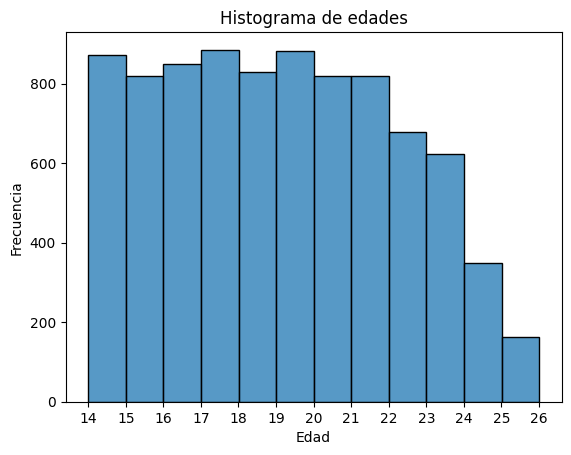

In [21]:
sns.histplot(metadata_train['Age'], binwidth=1, kde=False)
plt.title('Histograma de edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
min_age = int(metadata_train['Age'].min())
max_age = int(metadata_train['Age'].max())
plt.xticks(range(min_age, max_age + 1))
plt.show()

Las edades van de 14 a 26 años, siendo superior la muestra entre 14 a 21 y cada vez menor hasta los 26 años.

In [23]:
# # Código de referencia: https://plotly.com/python/parallel-categories-diagram/
# # Artículo de referencia: https://kosara.net/papers/2005/Bendix-InfoVis-2005.pdf

# # Ordenamos las filas del dataframe de metadatos de entrenamiento en orden ascendente de edad
# metadata_train = metadata_train.sort_values(by='Age', ascending=True)
# # Creamos una nueva columna en el dataframe con la edad convertida en entero 
# metadata_train['IntAge'] = np.floor(metadata_train['Age']).astype(int)

# # Build parcats dimensions
# categorical_dimensions = ['IntAge', 'Sex', 'Sample']
# dimensions = [dict(values=metadata_train[label], label=label) for label in categorical_dimensions]

# # Create a colorscale
# color = np.zeros(len(metadata_train), dtype='uint8')
# colorscale = [[0, '#00CCBF'], [1, 'firebrick']]

# # Build figure as FigureWidget
# fig = go.FigureWidget(
#     data=[
#         go.Parcats(
#         domain={'y': [0, 0.9]}, dimensions=dimensions,
#         labelfont={'size': 16}, tickfont={'size': 13},
#         line={'colorscale': colorscale, 'cmin': 0, 'cmax': 1,
#               'color': color, 'shape': 'hspline'},
#         arrangement='freeform')
#         ]
#     )

# fig.update_traces(dimensions=[{"categoryorder": "category ascending"} for _ in dimensions])

# # Update layout
# fig.update_layout(
#     width=900, height=700,
#     dragmode='lasso', hovermode='closest',
#     margin=dict(l=20, r=20, t=20, b=20),
# )

# # Update color callback
# def update_color(trace, points, state):
#     # Update parcats colors
#     new_color = np.zeros(len(metadata_train), dtype='uint8')
#     new_color[points.point_inds] = 1
#     fig.data[0].line.color = new_color

# # Register callback on parcats click
# fig.data[0].on_click(update_color)

# fig.show()

Este problema


radiografía maxilofacial

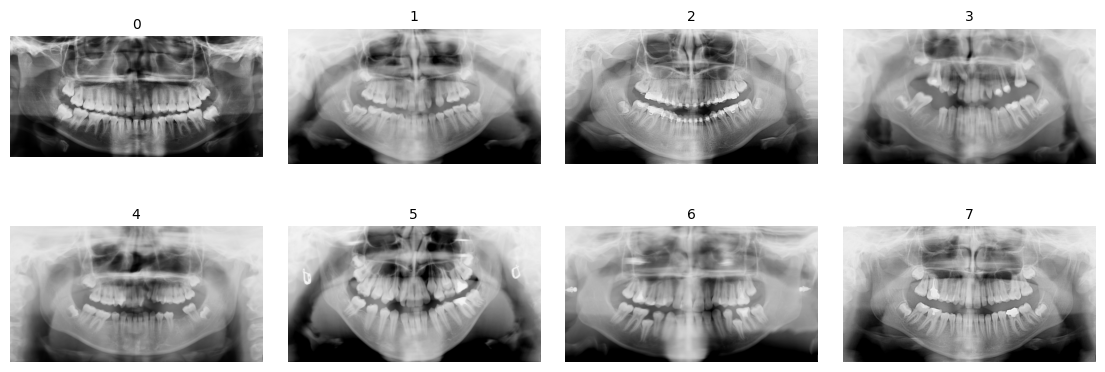

,ID,Sex,Age,Fold,Sample,IntAge
5051,UgandaO76.jpg,F,14.0,4.0,Africa,14
7789,Kosovo1315301157.jpg,F,14.0,0.0,Europe1,14
1056,Kosovo1915160282.jpg,F,14.0,3.0,Europe1,14
7264,Kosovo1115672735.jpg,M,14.0,2.0,Europe1,14
7015,Kosovo0315374924.jpg,F,14.0,0.0,Europe1,14
5921,Kosovo1915307608.jpg,F,14.0,1.0,Europe1,14
1750,Kosovo1315559612.jpg,F,14.0,2.0,Europe1,14
6778,Kosovo1315646612.jpg,F,14.0,1.0,Europe1,14


In [24]:
# Ruta base de las imágenes de train
base_dir_train = data_dir + 'train/'

# Seleccionamos los índices de las primeras 8 imágenes
index = range(8)

# Cargamos las imágenes correspondientes a esos índices 
images = [Image.open(os.path.join(base_dir_train, metadata_train.iloc[i]['ID'])) for i in index]

# Mostramos las imágenes
plot_images(images, index, fig_aspect=(1,0.7))

# Mostramos las filas del DataFrame correspondientes a esas imágenes
display(metadata_train.iloc[index])

## 3. Definición del protocolo de validación experimental y carga de datos

In [25]:
# Definimos las transformaciones que prepara las imágenes para ser procesadas por el modelo:
# - Redimensiona las imágenes a 448x224. Se ha escogido este tamaño dado que las imágenes son panorámicas y bastante 
#   maś anchas que altas.
# - Convertir la imagen a tensor, para que pueda ser manipulada por PyTorch.
# - Normalizar para ajustar la media y desviación típica de los canales RGB a los valores usados durante el entrenamiento 
#   en ImageNet.
transform = transforms.Compose(
    [transforms.Resize((448, 224)),  
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]
)

In [26]:
class MaxillofacialXRayDataset(Dataset):
    
    def __init__(self, metadata_file, images_dir, transform=None):
        """
        metadata_file: Ruta al archivo de metadatos (CSV u otro formato)
        images_dir: Ruta a la carpeta de imágenes (entrenamiento o prueba)
        transform: Transformaciones a aplicar a las imágenes (normalización, etc.)
        """
        self.metadata = pd.read_csv(metadata_file)  # Cargar los metadatos
        self.images_dir = images_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.metadata)
        
    def __getitem__(self, idx):
        """
        Obtener una imagen y su etiqueta por índice.
        """
        # Obtener el nombre de la imagen y su valor desde los metadatos
        img_name = os.path.join(self.images_dir, self.metadata.iloc[idx]['ID'])  # Ajusta según la estructura
        target = float(self.metadata.iloc[idx]['Age'])  # Ajusta según el formato de tus metadatos
        
        # Abrir la imagen
        image = Image.open(img_name)
        
        # Aplicar transformaciones si es necesario
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [28]:
# Crear el Dataset para entrenamiento
trainset = MaxillofacialXRayDataset(metadata_file = data_dir + 'metadata_train.csv',
                                    images_dir = data_dir + 'train/',
                                    transform = transform) 

# Obtenemos las edades enteras del trainset
intAges = np.floor(trainset.metadata['Age'].astype(float).to_numpy()).astype(int)
# Como vimos antes, hay una única instancia con edad 26, que el algoritmo de separación de entrenamiento 
# y validación será incapaz de dividir de forma estratificada. Para evitar el error, reasignamos esa 
# instancia a la edad inmediatamente inferior.
intAges[intAges==26]=25

#
BATCH_SIZE = 32

# Dividimos el conjunto de datos de forma estratificada en dos subconjuntos:
# - Entrenamiento (80% de las instancias)
# - Validación (20% de las instancias)

# 1) Dividimos el conjunto de datos de entrenamiento y validación
train_indices, valid_indices =  train_test_split(
                                    range(len(trainset)),
                                    train_size=0.80,
                                    shuffle=True,
                                    stratify=intAges
                                )

# 2) Creamos los subconjuntos para entrenamiento, validación y calibración
train_subset = Subset(trainset, train_indices)
valid_subset = Subset(trainset, valid_indices)

# 3) Creamos DataLoaders para cada subconjunto
train_loader =  DataLoader(
                    train_subset, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True, 
                    num_workers=2, 
                    pin_memory=True, 
                    worker_init_fn=seed_worker,
                    generator=g,
                )

valid_loader =  DataLoader(
                    valid_subset, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True, 
                    num_workers=2, 
                    pin_memory=True,
                    worker_init_fn=seed_worker,
                    generator=g,
                )

In [29]:
# Crear el Dataset para test
testset  =  MaxillofacialXRayDataset(
                metadata_file = data_dir + 'metadata_test.csv',
                images_dir = data_dir + 'test/',
                transform = transform
            ) 

# Crear el DataLoader para test
test_loader  =  DataLoader(
                    testset, 
                    batch_size=BATCH_SIZE, 
                    shuffle=False
                )

In [30]:
print(f"Número de imágenes en train_loader: {len(train_subset)}")
print(f"Número de imágenes en valid_loader: {len(valid_subset)}")
print(f"Número de imágenes en test_loader: {len(testset)}")

Número de imágenes en train_loader: 6869
Número de imágenes en valid_loader: 1718
Número de imágenes en test_loader: 2152


## 4. Definición y evaluación del modelo

### 4.1. Arquitectura del modelo


[Documentación de ResNeXt-50 32x4d](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnext50_32x4d.html)

A las capas convolucionales les da igual el tamaño de la imagen, pero las fully connected sí esperan un tamaño de entrada fijo.

In [31]:
class FeatureExtractorResNeXt(nn.Module):
    
    def __init__(self):
        
        super(FeatureExtractorResNeXt, self).__init__()
        
        resnext = torchvision.models.resnext50_32x4d(weights='DEFAULT')
        
        self.layer0 = nn.Sequential(
            resnext.conv1,
            resnext.bn1,
            resnext.relu,
            resnext.maxpool,
        )
        self.layer1 = resnext.layer1
        self.layer2 = resnext.layer2
        self.layer3 = resnext.layer3
        self.layer4 = resnext.layer4
        
        
    def forward(self, x):
        
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x



#
class ResNeXtRegressor(nn.Module):
    
    def __init__(self):
        
        super(ResNeXtRegressor, self).__init__()
        
        self.feature_extractor = FeatureExtractorResNeXt()
        
        # Nueva head
        self.pool_avg = nn.AdaptiveAvgPool2d((1,1))
        self.pool_max = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        
        fc1 = nn.Sequential(
            nn.BatchNorm1d(4096),  # 2048 (avg) + 2048 (max)
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True)
        )
        
        fc2 = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 1) 
        )
        
        self.regressor = nn.Sequential(fc1, fc2)

    def forward(self, x):
        x = self.feature_extractor(x)
        avg = self.pool_avg(x)
        max = self.pool_max(x)
        x = torch.cat([avg, max], dim=1) 
        x = self.flatten(x)
        x = self.regressor(x)
        return x


#
model = ResNeXtRegressor().to(device)

In [32]:
print(model)

ResNeXtRegressor(
  (feature_extractor): FeatureExtractorResNeXt(
    (layer0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [117]:
summary(model,(3, 448,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 112]           9,408
       BatchNorm2d-2         [-1, 64, 224, 112]             128
              ReLU-3         [-1, 64, 224, 112]               0
         MaxPool2d-4          [-1, 64, 112, 56]               0
            Conv2d-5         [-1, 128, 112, 56]           8,192
       BatchNorm2d-6         [-1, 128, 112, 56]             256
              ReLU-7         [-1, 128, 112, 56]               0
            Conv2d-8         [-1, 128, 112, 56]           4,608
       BatchNorm2d-9         [-1, 128, 112, 56]             256
             ReLU-10         [-1, 128, 112, 56]               0
           Conv2d-11         [-1, 256, 112, 56]          32,768
      BatchNorm2d-12         [-1, 256, 112, 56]             512
           Conv2d-13         [-1, 256, 112, 56]          16,384
      BatchNorm2d-14         [-1, 256, 

In [118]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# Usar la función
total_params, trainable_params = count_parameters(model)
print(f'Número total de parámetros: {total_params}')
print(f'Número de parámetros entrenables: {trainable_params}')

total_memory_gb = torch.cuda.get_device_properties(device).total_memory / 1024**3
memory_used_gb = torch.cuda.memory_allocated(device) / 1024**3
print(f"Memoria usada GPU: {memory_used_gb:.2f} de {total_memory_gb:.2f} GB")
# torch.cuda.empty_cache()

Número total de parámetros: 25087297
Número de parámetros entrenables: 25087297
Memoria usada GPU: 0.98 de 47.45 GB


### 4.2. Entrenamiento del modelo

In [119]:
def train(model, dataloader, loss_fn, optimizer, scheduler=None, device="cuda"):
    
    # Ponemos la red en modo entrenamiento (esto habilita el dropout)
    model.train()  
    
    # Inicializamos la pérdida acumulada para esta época
    epoch_loss = 0

    # Iteramos sobre todos los lotes de datos del DataLoader
    for inputs, targets in dataloader:
        
        # Obtenemos las imágenes de entrenamiento y sus valores objetivo
        inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)

        # Limpiamos los gradientes de la iteración anterior
        optimizer.zero_grad()           
        
        # Pasamos las imágenes de entrada a través de la red (propagación hacia adelante)
        outputs = model(inputs)       
        
        # Calculamos la pérdida de las predicciones
        loss = loss_fn(outputs, targets) 
        
        # Realizamos la retropropagación para calcular los gradientes (propagación hacia atrás)
        loss.backward()
        
        # Actualizamos los parámetros del modelo
        optimizer.step()            
        
        #
        if scheduler is not None:
            scheduler.step()   
 
        # Acumulamos la pérdida de este batch
        epoch_loss += loss.item()        
    
    # Calculamos la pérdida promedio de la época y la devolvemos
    avg_loss = epoch_loss / len(dataloader)
    return avg_loss

In [120]:
def evaluate(model, dataloader, metric_fn=None, device="cuda"):
    
    # Ponemos la red en modo evaluación (esto desactiva el dropout)
    model.eval()  
    
    # Inicializamos listas para almacenar las predicciones y los valores objetivo (target)
    all_predicted = []
    all_targets = []
    
    # No calculamos los gradientes durante la validación para ahorrar memoria y tiempo
    with torch.no_grad():
        
        # Iteramos sobre el conjunto a evaluar
        for inputs, targets in dataloader:
            
             # Obtenemos las imágenes de validación y sus valores objetivo
            inputs, targets = inputs.to(device), targets.to(device).float().unsqueeze(1)
            
            # Realizamos una predicción con el modelo
            outputs = model(inputs)
            
            # Almacenamos las predicciones y los targets
            all_predicted.append(outputs.cpu())
            all_targets.append(targets.cpu())

    # Concatenamos todas las predicciones y targets
    all_predicted = torch.cat(all_predicted)
    all_targets = torch.cat(all_targets)

    if metric_fn is None:
        return all_predicted, all_targets

    # Aplicamos la función de métrica y la devolvemos 
    metric_value = metric_fn(all_predicted, all_targets)
    return metric_value

In [34]:
# Ruta donde se guardará el modelo con mejor desempeño
best_model_path = models_dir + "model1.pth" 

# Definimos la función de pérdida a usar
criterion = nn.MSELoss()

#
base_lr = 1.5e-2
wd = 1e-4

# Configuramos el optimizador para ...
optimizer = torch.optim.AdamW(model.regressor.parameters(), lr=base_lr, weight_decay=wd)

In [122]:
# Congelamos los parámetros del extractor de características
for param in model.feature_extractor.parameters():
    param.requires_grad = False
    
# 
total_params, trainable_params = count_parameters(model)
print(f'Número total de parámetros: {total_params}')
print(f'Número de parámetros entrenables: {trainable_params}')

Número total de parámetros: 25087297
Número de parámetros entrenables: 2107393


In [123]:
# Entrenamos el modelo con el conjunto de entrenamiento
train_loss = train(model, train_loader, criterion, optimizer, device=device)

# Evaluamos el modelo con el conjunto de validación
valid_loss = evaluate(model, valid_loader, criterion, device=device)

#
print(f'Epoch 0 | Train Loss: {train_loss:.2f} | Validation Loss: {valid_loss:.2f}')

Epoch 0 | Train Loss: 40.31 | Validation Loss: 8.79


In [124]:
#    
for param in model.feature_extractor.parameters():
    param.requires_grad = True
    
# 
total_params, trainable_params = count_parameters(model)
print(f'Número total de parámetros: {total_params}')
print(f'Número de parámetros entrenables: {trainable_params}')

Número total de parámetros: 25087297
Número de parámetros entrenables: 25087297


In [125]:
# Número máximo de épocas a entrenar (si no se activa el early stopping)
MAX_EPOCHS = 30

# Número de épocas sin mejora antes de detener el entrenamiento
PATIENCE = 10

# Inicializamos la mejor pérdida de validación como infinito (para encontrar el mínimo)
best_valid_loss = float('inf')   

# Contador de épocas sin mejora
epochs_no_improve = 0  

# Establecemos las reglas para el learning rate discriminativo  
base_lr=1e-2             
lr_mult = 10                  
max_lr = base_lr/2              # Learning rate más alto, que se usará en las capas más superficiales 
min_lr = max_lr/lr_mult       # Learning rate más bajo, que se usará en las capas más profundas 

# Generamos una lista con los learning rates espaciados linealmente entre min_lr y max_lr
n_layers = 6
lrs = torch.linspace(min_lr, max_lr, n_layers)

# Creamos una lista donde guardar los parámetros del modelo por capas (de menor a mayor profundidad)
param_groups = []
param_groups.append({'params': model.feature_extractor.layer0.parameters(), 'lr':lrs[0].item()})
param_groups.append({'params': model.feature_extractor.layer1.parameters(), 'lr':lrs[1].item()})
param_groups.append({'params': model.feature_extractor.layer2.parameters(), 'lr':lrs[2].item()})
param_groups.append({'params': model.feature_extractor.layer3.parameters(), 'lr':lrs[3].item()})
param_groups.append({'params': model.feature_extractor.layer4.parameters(), 'lr':lrs[4].item()})
param_groups.append({'params': model.regressor.parameters(), 'lr':lrs[5].item()})

In [126]:
for i, group in enumerate(param_groups):
    print(f"Grupo {i}: LR = {group['lr']}, N° parámetros: {sum(p.numel() for p in group['params'])}") 

Grupo 0: LR = 0.0005000000237487257, N° parámetros: 9536
Grupo 1: LR = 0.00139999995008111, N° parámetros: 205824
Grupo 2: LR = 0.002300000051036477, N° parámetros: 1197056
Grupo 3: LR = 0.0031999999191612005, N° parámetros: 7022592
Grupo 4: LR = 0.004100000020116568, N° parámetros: 14544896
Grupo 5: LR = 0.004999999888241291, N° parámetros: 2107393


In [ ]:

# Configuramos el optimizador con los hiperparámetros escogidos
optimizer = torch.optim.AdamW(param_groups, lr=base_lr, weight_decay=wd)

# Crea el scheduler OneCycleLR
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=lrs.tolist(), 
    steps_per_epoch=len(train_loader),
    epochs=MAX_EPOCHS
)


In [ ]:
#
train_losses = []
valid_losses = []

# Temporizador de inicio
start_time = time.time()

# Bucle de entrenamiento por épocas
for epoch in range(MAX_EPOCHS):
    
    # Entrenamos el modelo con el conjunto de entrenamiento
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    
    # Evaluamos el modelo con el conjunto de validación
    valid_loss = evaluate(model, valid_loader, criterion, device)
    valid_losses.append(valid_loss)
    
    # Imprimimos las marcas de pérdidas obtenidas en entrenamiento y validación 
    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.2f} | Validation Loss: {valid_loss:.2f}')
    
    # Comprobamos si la pérdida en validación ha mejorado
    if valid_loss < best_valid_loss:
        
        # Actualizamos la mejor pérdida en validación obtenida hasta ahora
        best_valid_loss = valid_loss
        
        # Reiniciamos el contador de épocas sin mejora si la pérdida ha mejorado
        epochs_no_improve = 0
        
        # Guardamos los pesos del modelo actual como los mejores hasta ahora
        torch.save(model.state_dict(), best_model_path)
        
    else:
        # Incrementamos el contador si no hay mejora en la pérdida de validación
        epochs_no_improve += 1

    # Si no hay mejora durante un número determinado de épocas (patience), detenemos el entrenamiento
    if epochs_no_improve >= PATIENCE:
        print(f'Early stopping at epoch {epoch+1}')
        break
    

# Cargamos los pesos del modelo que obtuvo la mejor validación
model.load_state_dict(torch.load(best_model_path))

# Cálculo de tiempo total de entrenamiento 
end_time = time.time()
elapsed_time = end_time - start_time

print("Train losses: ", train_losses)
print("Validation losses: ", valid_losses)

Epoch 1 | Train Loss: 13.11 | Validation Loss: 10.12
Epoch 2 | Train Loss: 11.91 | Validation Loss: 9.62
Epoch 3 | Train Loss: 11.35 | Validation Loss: 10.06
Epoch 4 | Train Loss: 11.24 | Validation Loss: 9.50
Epoch 5 | Train Loss: 10.75 | Validation Loss: 9.44
Epoch 6 | Train Loss: 10.69 | Validation Loss: 10.46
Epoch 7 | Train Loss: 10.62 | Validation Loss: 10.32
Epoch 8 | Train Loss: 10.50 | Validation Loss: 9.03
Epoch 9 | Train Loss: 10.48 | Validation Loss: 9.35


Train losses:  [11.459232257133307, 11.196710693004519, 11.220551861164182, 11.210716249776441, 11.158293928102005, 11.255993344062983, 11.518110871869464, 11.235090934398562, 11.183449454640233, 11.186446205405302, 11.087010279367137, 11.273804642433344]
Validation losses:  [tensor(9.0096), tensor(8.8644), tensor(9.0438), tensor(9.0358), tensor(9.1258), tensor(9.0529), tensor(9.0405), tensor(8.9754), tensor(9.0131), tensor(9.2146), tensor(8.9650), tensor(9.1029)]


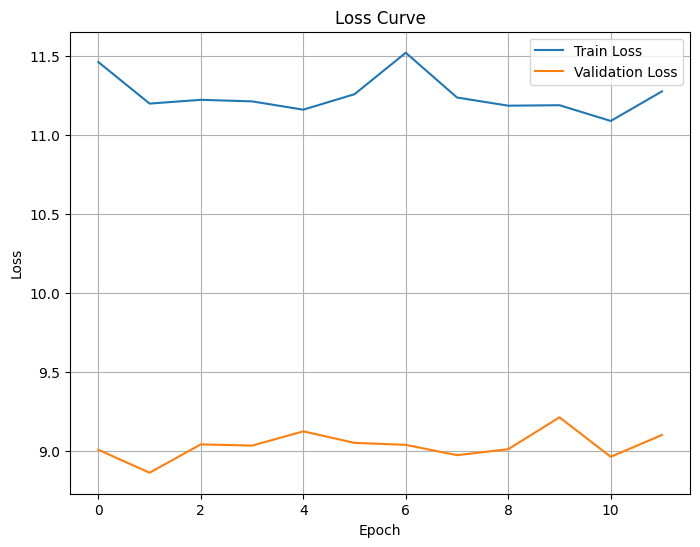

In [ ]:
print("Train losses: ", train_losses)
print("Validation losses: ", valid_losses)

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#
test_pred_values, test_true_values = evaluate(model, test_loader)

In [ ]:
# Calculamos el MAE final como métrica objetivo
test_mae = torch.mean(torch.abs(test_true_values - test_pred_values))
print(f'Error Absoluto Medio (MAE) en test: {test_mae:.2f}')

# Cálculo del MSE
test_mse = torch.mean((test_true_values - test_pred_values) ** 2)
print(f'Error Cuadrático Medio (MSE) en test: {test_mse:.2f}')

# Cálculo del R²
r2 = r2_score(test_true_values, test_pred_values)
print(f"R² en test: {r2:.4f}")

Error Absoluto Medio (MAE) en test: 2.46
Error Cuadrático Medio (MSE) en test: 8.98
R² en test: 0.0420
